In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
#import pytz
import scipy
import requests
import warnings
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

# Read in Excel Data

In [2]:
def read_in_data():
    excel_path = '/'.join(['.','Data',
                          'NBA Stats_2021-2023_01292024.xlsx'])
    
    print('  Reading in games...')
    games = pd.read_excel(excel_path,
                         sheet_name = 'Games',
                         header = 0,
                         index_col = 'game_id',
                         parse_dates = ['game_date'],
                         engine='openpyxl')
    
    print('  Reading in players...')
    players = pd.read_excel(excel_path,
                         sheet_name = 'Players',
                         header = 0,
                           index_col = 'player_id',
                           engine='openpyxl')
    
    print('  Reading in teams...')
    teams = pd.read_excel(excel_path,
                         sheet_name = 'Teams',
                         header = 0,
                         index_col = 'team_id',
                         engine='openpyxl')
    
    print('  Reading in stats...')
    stats = pd.read_excel(excel_path,
                         sheet_name = 'Stats',
                         header = 0,
                         engine='openpyxl')

    
    # Clean stats data and add column for fantasy points
    # Convert 'min' to numeric and fill NaN with 0
    stats['min'] = pd.to_numeric(stats['min'],
                                 errors = 'coerce')\
                    .fillna(0)

    # Shorthand turnover column
    stats.rename(columns = {'turnover':'to'},
                inplace = True)

    # Fantasy points (PrizePicks)
    ## Points = 1
    ## Rebound = 1.2
    ## Assists = 1.5
    ## Block = 3
    ## Steals = 3
    ## Turnover = -1
    stats['fpts'] = stats['pts']\
                    + (1.2 * stats['reb'])\
                    + (1.5 * stats['ast'])\
                    + (3 * stats['blk'])\
                    + (3 * stats['stl'])\
                    + (-1 * stats['to'])
    
    return games, players, teams, stats

In [3]:
games, players, teams, stats = read_in_data()

  Reading in games...
  Reading in players...
  Reading in teams...
  Reading in stats...


In [4]:
games.head()

,game_date,game_season,game_status,game_period,game_time,game_home_team_id,game_home_team_score,game_visitor_team_id,game_visitor_team_score,game_preseason,game_postseason
game_id,,,,,,,,,,,
473410,2021-10-19,2021,Final,4,NaN,17,127,3,104,N,False
473409,2021-10-19,2021,Final,4,NaN,14,114,10,121,N,False
473413,2021-10-20,2021,Final,4,NaN,28,83,30,98,N,False
473415,2021-10-20,2021,Final,4,NaN,15,132,6,121,N,False
473414,2021-10-20,2021,Final,6,NaN,20,138,2,134,N,False


In [5]:
players.head()

,player_team_id,player_position,player_full_name,player_first_name,player_last_name,player_height_feet,player_height_inches,player_weight_pounds
player_id,,,,,,,,
17896049,3,G,David Duke Jr.,David,Duke Jr.,NaN,NaN,NaN
17553995,14,G,Austin Reaves,Austin,Reaves,NaN,NaN,NaN
666543,14,F,Sekou Doumbouya,Sekou,Doumbouya,NaN,NaN,NaN
59,14,G,Avery Bradley,Avery,Bradley,6.0,2.0,180.0
220,14,C,Dwight Howard,Dwight,Howard,6.0,11.0,265.0


In [6]:
stats.head()

,id,game_id,player_id,team_id,opponent_team_id,min,fga,fgm,fg_pct,fta,ftm,ft_pct,fg3a,fg3m,fg3_pct,oreb,dreb,reb,pts,ast,stl,blk,pf,to,fpts
0,7315088,473410,17896049,3,17,0.0,0,0,0.000,0,0,0.00,0,0,0.000,0,0,0,0,0,0,0,0,0,0.0
1,7315614,473409,17553995,14,10,0.0,0,0,0.000,0,0,0.00,0,0,0.000,0,0,0,0,0,0,0,0,0,0.0
2,7315611,473409,666543,14,10,0.0,0,0,0.000,0,0,0.00,0,0,0.000,0,0,0,0,0,0,0,0,0,0.0
3,7315610,473409,59,14,10,8.0,3,2,0.667,0,0,NaN,3,2,0.667,1,0,1,6,1,0,0,2,1,7.7
4,7315612,473409,220,14,10,13.0,2,1,0.500,4,3,0.75,0,0,NaN,0,6,6,5,0,0,0,2,2,10.2


## Merge Game and Position Data

In [7]:
# Merge date of games
stats_dates = pd.merge(stats,
                      games[['game_date']],
                      how = 'left',
                      left_on = 'game_id',
                      right_index = True)\
                .sort_values(['game_date','player_id'])

In [8]:
# Merge player positions
stats_dates_pos = pd.merge(stats_dates,
                           players[['player_position']],
                           how = 'left',
                           left_on = 'player_id',
                           right_index = True)

# Parameters

In [9]:
# Determine rolling_period on rolling metrics for entire analysis
rolling_period = 62    # Based on number of observations/games, not number of days

# rolling_period_days = '120D'    # Based on number of days, not number of observations/games

In [10]:
stat_cats = ['pts']

In [11]:
valid_cats = ['fga','fgm',
              'fta','ftm',
              'fg3a','fg3m',
              'oreb','dreb','reb',
              'pts','ast',
              'stl','blk',
              'pf','to']

invalid_cats = [cat for cat in stat_cats if cat not in valid_cats]

if len(invalid_cats) > 0:
    raise KeyError('Invalid statistical category provided')

In [12]:
cats_pergame_name_map = {cat:cat+'_pg' for cat in valid_cats}

# Add/Impute Statistics

## Team Stats

In [13]:
stats_dates_pos.head()

,id,game_id,player_id,team_id,opponent_team_id,min,fga,fgm,fg_pct,fta,ftm,ft_pct,fg3a,fg3m,fg3_pct,oreb,dreb,reb,pts,ast,stl,blk,pf,to,fpts,game_date,player_position
26,7315084,473410,6,3,17,16.0,2,0,0.000,4,1,0.250,0,0,NaN,0,3,3,1,1,0,1,2,1,8.1,2021-10-19,F
35,7315097,473410,8,17,3,28.0,10,3,0.300,1,1,1.000,10,3,0.30,0,4,4,10,6,2,0,0,0,29.8,2021-10-19,G
48,7315095,473410,15,17,3,31.0,25,12,0.480,9,7,0.778,4,1,0.25,5,9,14,32,7,1,2,4,4,64.3,2021-10-19,F
6,7315609,473409,17,14,10,26.0,9,3,0.333,2,1,0.500,4,2,0.50,0,4,4,9,2,0,0,2,1,15.8,2021-10-19,F
9,7315607,473409,36,14,10,31.0,9,3,0.333,0,0,NaN,8,2,0.25,0,2,2,8,0,0,1,4,1,12.4,2021-10-19,G


In [14]:
def team_rolling_mean(group):
    group_indexed = group.set_index('game_date')
    
    rolling_group = group_indexed\
                    [stat_cats]\
                    .rolling(rolling_period,
                             min_periods = 1)\
                    .mean()\
                    .rename(columns = cats_pergame_name_map)
    
    return rolling_group

### Defensive Efficiency by Position

In [15]:
team_def_eff_pos = stats_dates_pos\
                        .groupby(['opponent_team_id','game_date','player_position'])\
                        [stat_cats]\
                        .sum()\
                        .reset_index()

In [16]:
team_stats_rolling_def_eff = team_def_eff_pos.groupby(['opponent_team_id','player_position'])\
                            .apply(team_rolling_mean)\
                            .reset_index()\
                            .rename(columns = {'opponent_team_id':'team_id'})

team_stats_rolling_def_eff.rename(columns = {value:'opp_'+value
                                             for key,value in cats_pergame_name_map.items()},
                                 inplace = True)

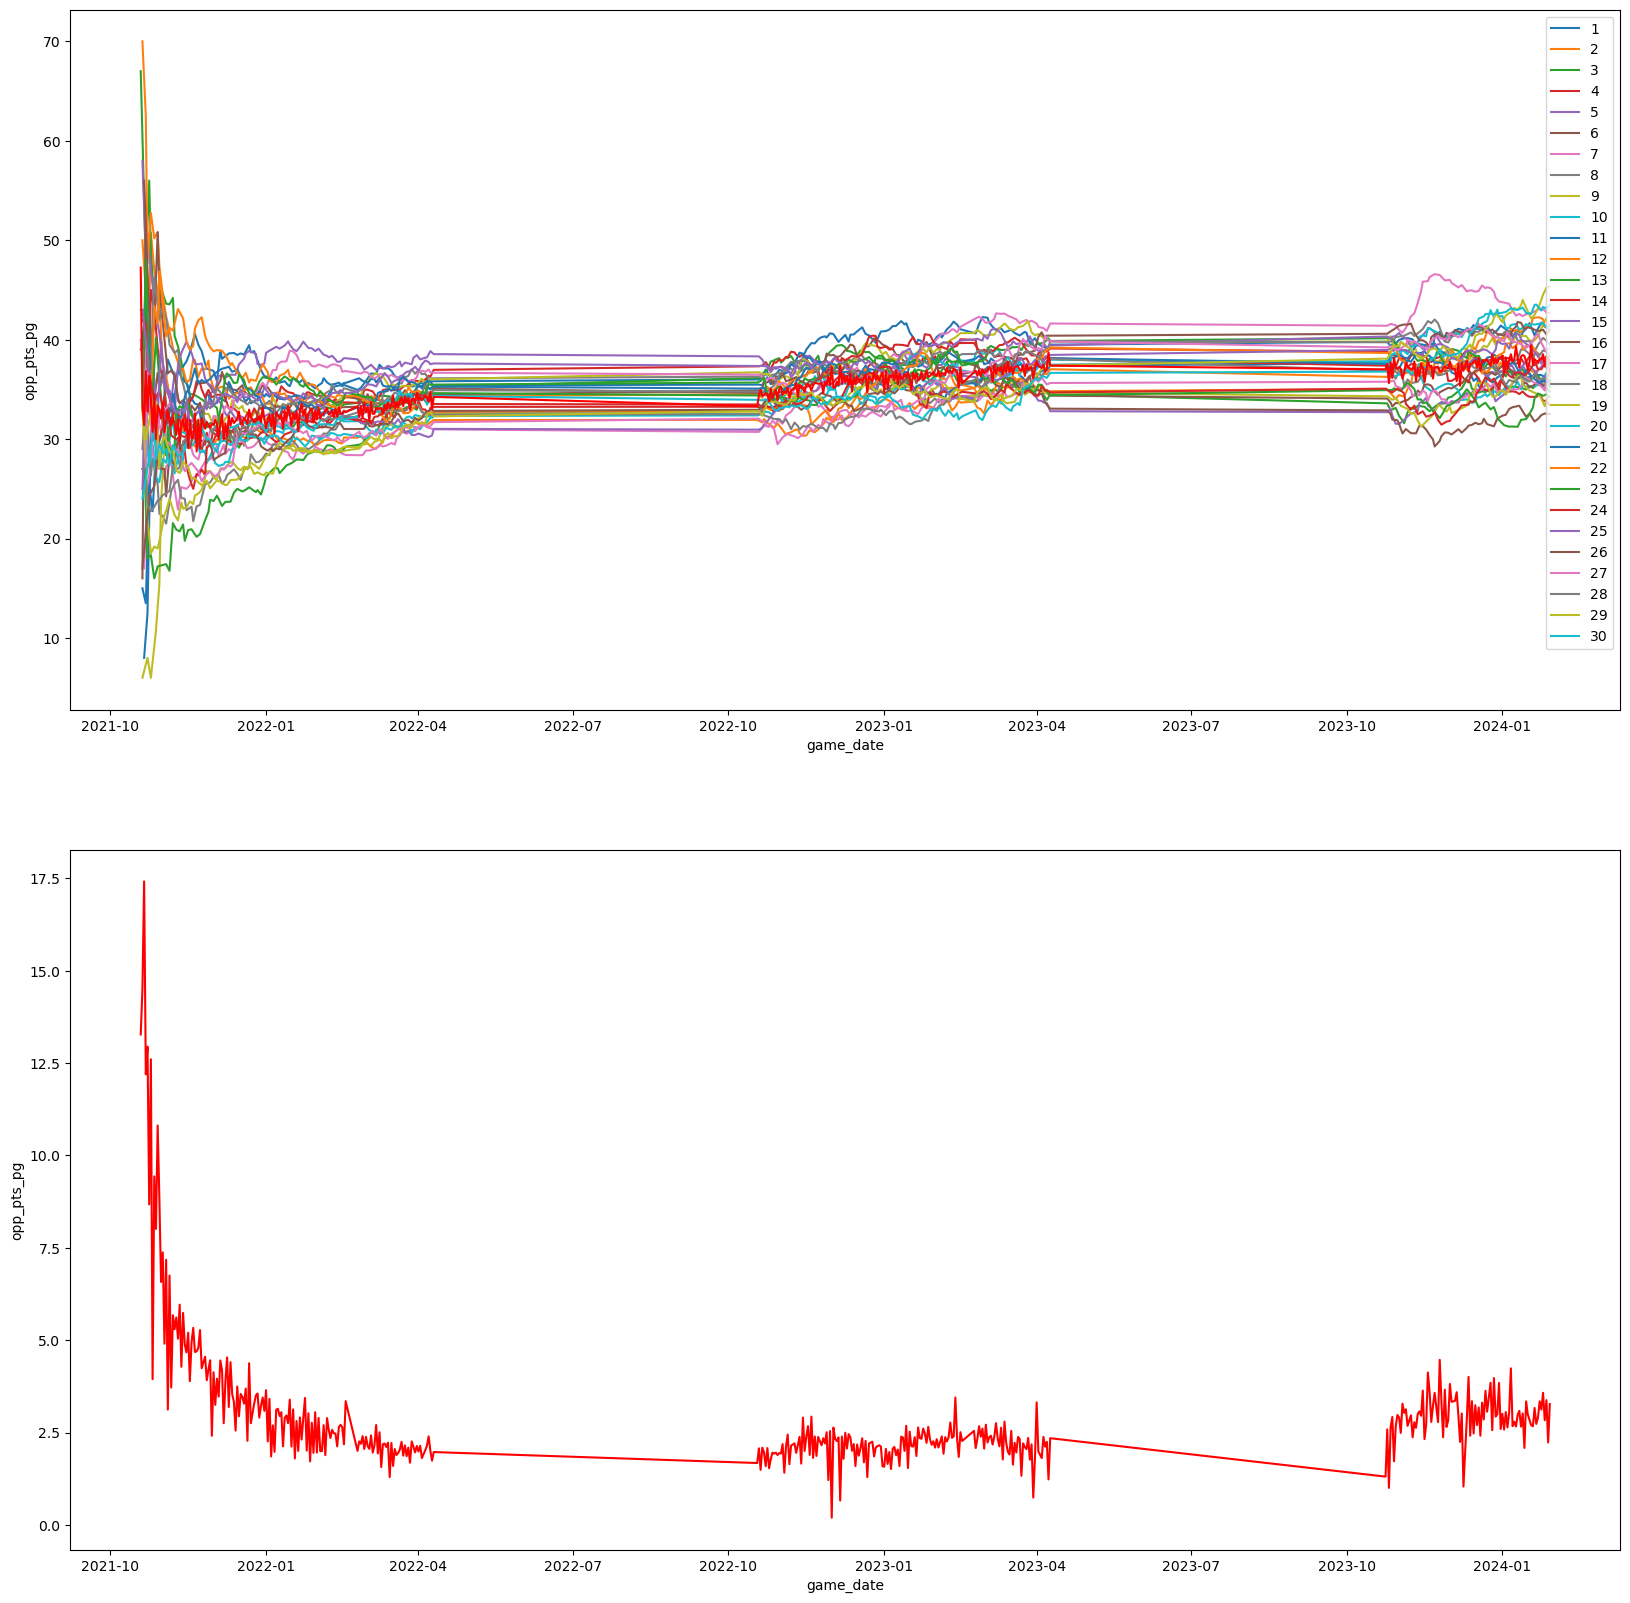

In [17]:
player_position = 'F'

fig = plt.figure(figsize = (20,20))
ax = plt.subplot(2,1,1)
sns.lineplot(data = team_stats_rolling_def_eff[team_stats_rolling_def_eff['player_position'] == player_position],
                  x = 'game_date',
                  y = 'opp_pts_pg',
                  hue = 'team_id',
                  palette = sns.color_palette(),
                  ci = None)
ax2 = sns.lineplot(data = team_stats_rolling_def_eff[team_stats_rolling_def_eff['player_position'] == player_position]\
                           .groupby('game_date')\
                           [['opp_pts_pg']]\
                           .mean()\
                           .reset_index(),
                  x = 'game_date',
                  y = 'opp_pts_pg',
                   color = 'red',
                  dashes = True)
plt.legend(loc = 'upper right')

ax = plt.subplot(2,1,2)
ax2 = sns.lineplot(data = team_stats_rolling_def_eff[team_stats_rolling_def_eff['player_position'] == player_position]\
                           .groupby('game_date')\
                           [['opp_pts_pg']]\
                           .std()\
                           .reset_index(),
                  x = 'game_date',
                  y = 'opp_pts_pg',
                   color = 'red',
                  dashes = True)

fig.show()

#### Ranking Team Defensive Capability by Position

In [18]:
team_def_eff_resampled = team_stats_rolling_def_eff.set_index('game_date')\
                            .groupby(['team_id',
                                      'player_position'])\
                            .resample('1D')\
                            [['opp_pts_pg']]\
                            .ffill()\
                            .reset_index()

In [19]:
team_def_eff_ranked = team_def_eff_resampled.groupby(['game_date','player_position'])\
                        .apply(lambda x: x.set_index('team_id')
                                           [['opp_pts_pg']]\
                                           .rank(method = 'min',
                                                 na_option = 'bottom')\
                              )\
                        .reset_index()

In [20]:
team_def_eff_pos_mean = team_def_eff_ranked.groupby(['team_id','player_position'])[['opp_pts_pg']].mean().reset_index()
team_def_eff_pos_mean_pivoted = pd.pivot_table(team_def_eff_pos_mean,
                                               index = 'player_position',
                                               columns = 'team_id')

In [21]:
team_def_eff_pos_mean_pivoted

opp_pts_pg                                              \
team_id                 1          2          3          4          5    
player_position                                                          
C                15.679518   4.683894  14.483794  24.082933  10.315283   
F                25.591566   7.706731  14.250900  22.155048  17.665463   
F-C              17.710843  20.313559  13.513253  25.437500  20.271961   
G                11.348193   6.694712  18.174070  12.153846  12.913357   
G-F              20.869880  18.354217  19.543478  15.735577   7.980746   
UNK              22.033251  16.067797  19.401709  21.260816  23.356098   

                                                                        \
team_id                 6          7          8          9          10   
player_position                                                          
C                13.585337  18.962696  17.094952  20.506619   7.063779   
F                12.709135  16.187726  16.028846  23.604091  11.316486   
F-C               7.138221   4.942029  12.060241  23.704600  13.613718   
G                 3.879808  11.998797  15.296875  15.883273  15.234657   
G-F              15.963942   4.361111  12.417874  10.178099  25.127427   
UNK              12.632282  10.362864   5.431447  18.321429   2.607407   

                                                                        \
team_id                 11         12         13         14         15   
player_position                                                          
C                19.896635  22.040915  13.717732  11.240964  18.078125   
F                18.102163  14.835138  17.935018  15.803121  15.318510   
F-C               9.507212  21.665463  26.075995  18.907229   5.067389   
G                23.574519  26.240674  10.056558  23.979592  12.423077   
G-F              12.901205  13.711353  13.683514  21.349340  13.725632   
UNK              24.596814   6.484223   2.300725   6.459687  18.361416   

                                                                        \
team_id                 16         17         18         19         20   
player_position                                                          
C                 8.419976  12.510229  12.562123  16.512019   4.558894   
F                12.785800  15.518607  22.080529   6.256010  12.841346   
F-C               2.709288  24.082833  18.350962  14.754808  20.831325   
G                 9.346570  14.439376  20.692308  15.518029  11.450721   
G-F               7.385732  11.356543  11.424608  27.839566   8.849398   
UNK              26.797834  18.206107  25.899363  14.271499  14.242054   

                                                                        \
team_id                 21         22         23         24         25   
player_position                                                          
C                14.247596  13.753606  17.213942  11.025240  22.806490   
F                18.957933  16.572115  13.777644   9.882212  22.390625   
F-C               6.600962  24.732769  13.577108   9.758413  11.300481   
G                20.686298  13.358173   6.036058  16.306490  18.084135   
G-F              20.437727  12.328125  22.201923   8.877404  20.032648   
UNK              10.101110  15.138686  14.006305  23.378606  23.971570   

                                                                        
team_id                 26         27         28         29         30  
player_position                                                         
C                26.377404  28.716867  10.119421  11.237981  21.900000  
F                17.056490  13.270433  11.197353   9.519231  12.111779  
F-C              10.637349  11.781401  23.019254  10.213942  21.325301  
G                22.487981  27.033654   8.007220  21.411058  19.685096  
G-F              24.802885  19.348613  13.644150  22.048077   7.360577  
UNK              11.334951  18.294046   3.059202  19.668712   9.160200

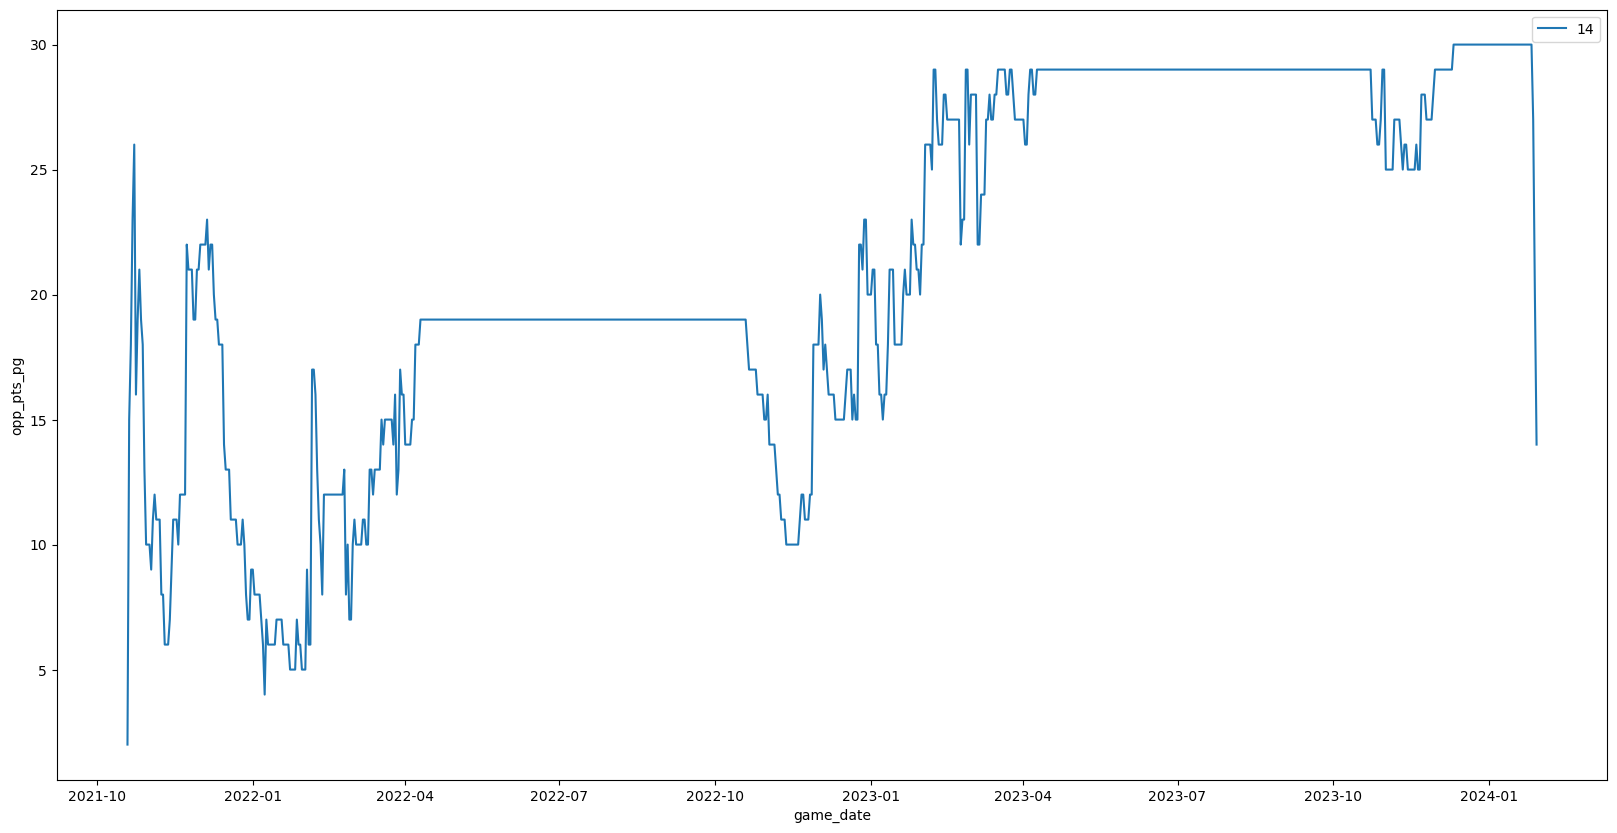

In [22]:
player_position = 'G-F'

fig = plt.figure(figsize = (20,10))
ax = sns.lineplot(data = team_def_eff_ranked[(team_def_eff_ranked['player_position'] == player_position)
                                              & (team_def_eff_ranked['team_id'] == 14)],
                  x = 'game_date',
                  y = 'opp_pts_pg',
                  hue = 'team_id',
                  palette = sns.color_palette(),
                  ci = None)
plt.legend(loc = 'upper right')
fig.show()

### Offensive Efficiency by Position

In [23]:
team_off_eff_pos = stats_dates_pos\
                        .groupby(['team_id','game_date','player_position'])\
                        [stat_cats]\
                        .sum()\
                        .reset_index()

In [24]:
team_stats_rolling_off_eff = team_off_eff_pos.groupby(['team_id','player_position'])\
                            .apply(team_rolling_mean)\
                            .reset_index()

### Merge Team Defensive and Offensive Efficiency by Position

In [25]:
team_eff_pos = pd.merge(team_stats_rolling_off_eff,
                        team_stats_rolling_def_eff,
                        how = 'outer',
                        left_on = ['team_id','game_date','player_position'],
                        right_on = ['team_id','game_date','player_position'])

### League Team Averages

In [26]:
def league_team_stats(group):
    '''
    Grouping function to get standard deviation of stat per36 for each player on a given date
    Need to account for offseason/days where there are no games
    '''
    team_stat_cats = ['_'.join([cat,'pg']) for cat in stat_cats]
    opp_stat_cats = ['_'.join(['opp',cat,'pg']) for cat in stat_cats]

    resample_stat_cats = team_stat_cats + opp_stat_cats
    
    # Sort by date and player prior to resampling
    group_sorted = group.sort_values(['game_date','team_id'])\
                        .set_index(['game_date'])
    
    # Resample data to daily by each player
    ## Forward fill blank values
    group_resampled = group_sorted.groupby('team_id')\
                        .resample('1D')\
                        [resample_stat_cats]\
                        .last()
    
    # Were games played on date
    ## Due to resample, dates in the off season were added
    ## Need to remove; will cause calculations over at the beginning of each season
    date_no_minutes = group_resampled.groupby(level = 1)\
                        .apply(lambda x: x.isna()\
                                           .all()
                              )
    
    # Drop dates with no games
    ## Includes in-season breaks
    date_no_games = date_no_minutes[(date_no_minutes == True).all(axis = 1)].index
    
    group_resampled.drop(index = date_no_games,
                        level = 1,
                        inplace = True)
    
    # Forward fill values by player
    final_group_resampled = group_resampled.groupby(level = [0])[resample_stat_cats].ffill()
    
    # Calculate the standard deviation of pts_per36 for all players by date
    final_rolling_stats = final_group_resampled.groupby(level = 1).agg(['mean',
                                                                        'std'])
    
    return final_rolling_stats

In [27]:
# Calculate teams offensive pts production by position per game
team_pos_off_total = stats_dates_pos.groupby(['game_date',
                                                  'player_position',
                                                  'team_id'])\
                            [stat_cats]\
                            .sum()\
                            .reset_index()\
                            .rename(columns = cats_pergame_name_map)

# Calculate teams defensive pts production by position per game
team_pos_def_total = stats_dates_pos.groupby(['game_date',
                                                  'player_position',
                                                  'opponent_team_id'])\
                            [stat_cats]\
                            .sum()\
                            .reset_index()\
                            .rename(columns = {'opponent_team_id':'team_id'})

team_pos_def_total.rename(columns = {key:'opp_'+value
                                         for key,value in cats_pergame_name_map.items()},
                             inplace = True)

# Merge teams offensive and defensive production by position
team_pos_eff_total = pd.merge(team_pos_off_total,
                               team_pos_def_total,
                               how = 'outer',
                               left_on = ['game_date','team_id','player_position'],
                               right_on = ['game_date','team_id','player_position'])

In [28]:
team_pos_rolling_eff = team_pos_eff_total\
                        .groupby('player_position')\
                        .apply(league_team_stats)

In [29]:
team_pos_rolling_eff.columns = ['_'.join(i) for i in team_pos_rolling_eff.columns]

In [30]:
team_pos_rolling_eff.reset_index(inplace = True)

## Player Stats

### Individual Player Efficiency

In [31]:
player_stat_cats = stat_cats + ['min']

In [32]:
def player_rolling_sum(group):
    group_indexed = group.sort_values('game_date')\
                    .set_index('game_date')
    
    rolling_group = group_indexed\
                        [player_stat_cats]\
                       .rolling(rolling_period,
                                min_periods = 1)\
                       .sum()
    
    rolling_min_mean = group_indexed\
                        [['min']]\
                        .rolling(rolling_period,
                                 min_periods = 1)\
                        .mean()
    
    rolling_merged = pd.merge(rolling_min_mean,
                              rolling_group,
                              how = 'outer',
                              left_index = True,
                              right_index = True,
                             suffixes = ['_mean','_cumsum'])
    
    return rolling_merged

In [33]:
player_stats_rolling_eff = stats_dates.groupby('player_id')\
                            .apply(player_rolling_sum)

In [34]:
player_stats_rolling_eff

min_mean   pts  min_cumsum
player_id game_date                             
3         2021-10-20     32.00   8.0        32.0
          2021-10-23     29.50  25.0        59.0
          2021-10-24     31.00  39.0        93.0
          2021-10-27     27.75  43.0       111.0
          2021-10-28     26.40  55.0       132.0
...                        ...   ...         ...
59421201  2023-12-13      0.00   0.0         0.0
          2023-12-15      0.00   0.0         0.0
          2023-12-16      0.00   0.0         0.0
          2023-12-18      0.00   0.0         0.0
          2023-12-20      0.00   0.0         0.0

[96937 rows x 3 columns]

In [35]:
for cat in stat_cats:
    player_stats_rolling_eff[cat+'_per36'] = player_stats_rolling_eff[cat] * (36/player_stats_rolling_eff['min_cumsum'])

In [36]:
actual_eff_merged = pd.merge(stats_dates_pos[['game_date','player_id','player_position',
                                              'min'] + stat_cats],
                             player_stats_rolling_eff.reset_index()\
                                 .drop(stat_cats + ['min_cumsum'],
                                      axis = 1),
                             how = 'left',
                             left_on = ['player_id','game_date'],
                             right_on = ['player_id','game_date'])#\
                    #.sort_values(['player_id','game_date'])

In [37]:
per36_stat_cols = [i for i in actual_eff_merged.columns if ('_per36' in i)]

### League Position Average

In [38]:
def league_player_pts_stats(group):
    '''
    Grouping function to get standard deviation of pts_per36 for each player on a given date
    Need to account for offseason/days where there are no games
    '''
    # Sort by date and player prior to resampling
    group_sorted = group.sort_values(['game_date','player_id'])\
                        .set_index(['game_date'])
    
    # Resample data to daily by each player
    ## Forward fill blank values
    group_resampled = group_sorted.groupby(['player_id',
                                           ])\
                        .resample('1D')\
                        [per36_stat_cols]\
                        .last()
    
    # Were games played on date
    ## Due to resample, dates in the off season were added
    ## Need to remove; will cause calculations over at the beginning of each season
    date_no_minutes = group_resampled.groupby(level = 1)\
                        .apply(lambda x: x.isna()\
                                           .all()
                              )
    
    # Drop dates with no games
    ## Includes in-season breaks
    date_no_games = date_no_minutes[(date_no_minutes[per36_stat_cols] == True).all(axis = 1)].index
    
    group_resampled.drop(index = date_no_games,
                        level = 1,
                        inplace = True)
    
    # Forward fill values by player
    final_group_resampled = group_resampled.groupby(level = [0])[per36_stat_cols].ffill()
    
    # Calculate the standard deviation of pts_per36 for all players by date
    final_rolling_stats = final_group_resampled.groupby(level = [1]).agg(['mean',
                                                                          'std'])
    final_rolling_stats.columns = ['_'.join(i) for i in final_rolling_stats.columns]
    
    return final_rolling_stats

In [39]:
league_player_rolling_stats = actual_eff_merged.groupby('player_position',
                                                       dropna = False)\
                                .apply(league_player_pts_stats)

In [40]:
league_player_rolling_stats

pts_per36_mean  pts_per36_std
player_position game_date                                
C               2021-10-19        9.890110       4.167951
                2021-10-20       15.648623       7.949697
                2021-10-21       17.388892       9.092027
                2021-10-22       17.848332       8.883323
                2021-10-23       17.205380       8.062361
...                                    ...            ...
UNK             2024-01-25       12.513460       2.383191
                2024-01-26       12.495996       2.303895
                2024-01-27       12.411966       2.334460
                2024-01-28       12.466078       2.634246
                2024-01-29       11.466238       1.761111

[2514 rows x 2 columns]

In [41]:
league_player_rolling_stats.reset_index(inplace = True)

## Shift Data
Need to shift team efficiency, player efficiency, and league rolling data down a row so they can be used as dependent variables on the actual predictor variable

In [42]:
team_eff_pos_shifted = team_eff_pos.groupby(['team_id','player_position'])\
                        .apply(lambda x: x.sort_values('game_date')\
                                           .set_index('game_date')\
                                           [[col for col in team_eff_pos.columns if col.endswith('_pg')]]\
                                           .shift(1))\
                        .reset_index()

In [64]:
team_pos_rolling_eff_shifted = team_pos_rolling_eff.groupby('player_position')\
                                .apply(lambda x: x.sort_values('game_date')\
                                                   .set_index('game_date')\
                                                   [[col for col in team_pos_rolling_eff.columns if '_pg_' in col]]\
                                                   .shift(1))\
                                .reset_index()

In [44]:
actual_eff_merged_shifted = actual_eff_merged.groupby(['player_id','player_position'])\
                                .apply(lambda x: x.sort_values('game_date')\
                                                   .set_index('game_date')\
                                                   [per36_stat_cols + ['min_mean']]\
                                                   .shift(1))\
                                .reset_index()

In [46]:
league_player_rolling_stats_shifted = league_player_rolling_stats.groupby('player_position')\
                                        .apply(lambda x: x.sort_values('game_date')\
                                                           .set_index('game_date')\
                                                           [[col for col in league_player_rolling_stats.columns if '_per36_' in col]]\
                                                           .shift(1))\
                                        .reset_index()

## Merge Data

### Merge Team Stats

In [84]:
rolling_stats_teams = pd.merge(team_eff_pos_shifted.rename(columns = {col:'team_'+col
                                                                      for col in team_eff_pos_shifted.columns
                                                                      if col.endswith('_pg')}),
                               team_pos_rolling_eff_shifted.rename(columns = {col:'league_'+col
                                                                              for col in team_pos_rolling_eff_shifted.columns
                                                                              if '_pg_' in col}),
                               how = 'outer',
                               left_on = ['player_position','game_date'],
                               right_on = ['player_position','game_date'])\
                        .sort_values(['game_date','player_position','team_id'])

### Merge Player Stats

In [66]:
rolling_stats_players = pd.merge(actual_eff_merged_shifted.rename(columns = {**{'min_mean':'player_avg_min'},\
                                                                             **{col:'player_'+col for col in per36_stat_cols}
                                                                            }),
                                 league_player_rolling_stats_shifted.rename(columns = {col:'league_player_'+col
                                                                                       for col in league_player_rolling_stats_shifted
                                                                                       if '_per36_' in col}),
                                 how = 'outer',
                                 left_on = ['player_position','game_date'],
                                 right_on = ['player_position','game_date'])\
                        .sort_values(['game_date','player_position','player_id'])

### Merge Player and Team Stats to Relevant Stats

In [67]:
# Table of relevant fields from original data
rel_stats = stats_dates_pos[['game_date',
                             'player_id','player_position',
                             'team_id','opponent_team_id',
                             'min']
                            + stat_cats]

In [68]:
rel_rolling_players = pd.merge(rel_stats,
                               rolling_stats_players,
                               how = 'outer',
                               left_on = ['game_date','player_id','player_position'],
                               right_on = ['game_date','player_id','player_position'])
                         

In [86]:
rolling_stats_teams

,team_id,player_position,game_date,team_pts_pg,team_opp_pts_pg,league_pts_pg_mean,league_pts_pg_std,league_opp_pts_pg_mean,league_opp_pts_pg_std
24330,3,C,2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN
24331,10,C,2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN
24332,14,C,2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN
24333,17,C,2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN
24868,3,F,2021-10-19,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
31699,16,UNK,2024-01-29,3.645161,NaN,6.285714,5.376315,6.0,9.746794
31700,17,UNK,2024-01-29,0.790323,NaN,6.285714,5.376315,6.0,9.746794
31701,23,UNK,2024-01-29,3.354839,NaN,6.285714,5.376315,6.0,9.746794
31702,24,UNK,2024-01-29,3.561404,NaN,6.285714,5.376315,6.0,9.746794


In [91]:
rel_rolling_team_off = pd.merge(rel_rolling_players,
                                rolling_stats_teams[['team_id','player_position','game_date']
                                                    + [col for col in rolling_stats_teams if (('_pg' in col)
                                                                                              & ('_opp_' not in col))]],
                                how = 'left',
                                left_on = ['game_date','team_id','player_position'],
                                right_on = ['game_date','team_id','player_position'])

In [101]:
rel_rolling_team_opp = pd.merge(rel_rolling_team_off,
                                rolling_stats_teams[['team_id','player_position','game_date']
                                                    + [col for col in rolling_stats_teams if (('_pg' in col)
                                                                                              & ('_opp_' in col))]]\
                                    .rename(columns = {col:'opponent_'+col
                                                       for col in rolling_stats_teams.columns
                                                       if ('team_opp_' in col)}),
                                how = 'left',
                                left_on = ['game_date','opponent_team_id','player_position'],
                                right_on = ['game_date','team_id','player_position'],
                               suffixes = ['','_y'])\
                        .drop('team_id_y',
                              axis = 1)

### Standardize Data

In [103]:
rel_rolling_team_opp

,game_date,player_id,player_position,team_id,opponent_team_id,min,pts,player_pts_per36,player_avg_min,league_player_pts_per36_mean,league_player_pts_per36_std,team_pts_pg,league_pts_pg_mean,league_pts_pg_std,opponent_team_opp_pts_pg,league_opp_pts_pg_mean,league_opp_pts_pg_std
0,2021-10-19,6,F,3,17,16.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-10-19,8,G,17,3,28.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-10-19,15,F,17,3,31.0,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-10-19,17,F,14,10,26.0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-10-19,36,G,14,10,31.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97076,2024-01-29,56677866,F,4,20,12.0,0,11.172414,1.977273,14.762533,5.561374,50.258065,43.689655,22.187679,41.225806,42.413793,20.410987
97077,2024-01-29,56677871,F,8,17,0.0,0,2.769231,0.553191,14.762533,5.561374,29.806452,43.689655,22.187679,36.080645,42.413793,20.410987
97078,2024-01-29,56677872,G,6,13,0.0,0,16.095032,10.767442,15.667896,5.605685,66.129032,42.862069,18.579413,51.225806,42.448276,20.201814
97079,2024-01-29,56783340,C,25,23,4.0,0,18.413115,13.260870,14.810021,4.649576,13.306452,11.333333,12.291335,10.774194,10.888889,11.081285


In [ ]:
for cat in stat_cats:
    # Team Data Standardization
    rel_rolling_team_opp['team_'+cat+'_pg_stand'] = (rel_rolling_team_opp['team_'+cat+'_pg'] - rel_rolling_team_opp['league_'+cat+'_pg_mean'])/rel_rolling_team_opp['league_'+cat+'_pg_std']

    # Opponent Team Data Standardization
    rel_rolling_team_opp['opponent_team_'+cat+'_pg_stand'] = (rel_rolling_team_opp['opponent_team_opp_'+cat+'_pg'] - rel_rolling_team_opp['league_opp_'+cat+'_pg_mean'])/rel_rolling_team_opp['league_opp_'+cat+'_pg_std']
    
    # Player Data Standardization
    rel_rolling_team_opp['player_'+cat+'_per36_stand'] = (rel_rolling_team_opp['player_'+cat+'_per36'] - rel_rolling_team_opp['league_player_'+cat+'_per36_mean'])/rel_rolling_team_opp['league_player_'+cat+'_per36_std']

### Plotting

#### Team Data

In [ ]:
rel_rolling_team_opp[(rel_rolling_team_opp['game_date'] > '2021-12-01')
                        & (rel_rolling_team_opp['player_position'] != 'UNK')]['opp_def_ppg_stand'].max()

In [ ]:
rel_rolling_team_opp[rel_rolling_team_opp['opp_def_ppg_stand'] == rel_rolling_team_opp[(rel_rolling_team_opp['game_date'] > '2021-12-01')
                        & (rel_rolling_team_opp['player_position'] != 'UNK')]['opp_def_ppg_stand'].max()]

In [ ]:
rel_rolling_team_opp[(rel_rolling_team_opp['opponent_team_id'] == 2)
                        & (rel_rolling_team_opp['player_position'] == 'G-F')]\
    [['game_date','opp_def_ppg_stand']]\
    .drop_duplicates()

In [ ]:
opponent_team_id = 6
opponent_team_name = teams[teams.index == opponent_team_id]['team_name'][opponent_team_id]
player_position = 'G-F'

fig = plt.figure(figsize = (20,10))
ax = sns.pointplot(data = rel_rolling_team_opp[(rel_rolling_team_opp['opponent_team_id'] == opponent_team_id)
                                               & (rel_rolling_team_opp['player_position'] == player_position)]\
                            [['game_date','opp_def_ppg_stand']]\
                            .drop_duplicates(),
                   x = 'game_date',
                   y = 'opp_def_ppg_stand',
                  ci = None)
ax.set_title('%s vs. %s' %(opponent_team_name, player_position))
ax.set_xlabel('Game Date')
ax.set_ylabel('Standard Deviation')

# xaxis_date_format = mdates.DateFormatter('%y-%m')
# plt.gca().xaxis.set_major_formatter(xaxis_date_format)

plt.xticks(rotation=90)
# fig.tight_layout()
fig.show()

In [ ]:
team_id = 10
team_name = teams[teams.index == team_id]['team_name'][team_id]
player_position = 'G'

fig = plt.figure(figsize = (20,10))
ax = sns.pointplot(data = rel_rolling_team_opp[(rel_rolling_team_opp['team_id'] == team_id)
                                               & (rel_rolling_team_opp['player_position'] == player_position)]\
                            [['game_date','team_off_ppg_stand']]\
                            .drop_duplicates(),
                   x = 'game_date',
                   y = 'team_off_ppg_stand',
                  ci = None)
ax.set_title('%s %s vs. League' %(team_name, player_position))
ax.set_xlabel('Game Date')
ax.set_ylabel('Standard Deviation')

# xaxis_date_format = mdates.DateFormatter('%y-%m')
# plt.gca().xaxis.set_major_formatter(xaxis_date_format)

plt.xticks(rotation=90)
# fig.tight_layout()
fig.show()

#### Player Data

In [ ]:
rel_rolling_team_opp[rel_rolling_team_opp['player_id'] == 175]

In [ ]:
player_id = 37

fig = plt.figure(figsize = [30,10])
ax = sns.pointplot(data = rel_rolling_team_opp[rel_rolling_team_opp['player_id'] == player_id],
                 x = 'game_date',
                 y = 'player_pts_per36_stand',
                ci = None # Confidence Interval
                )
ax.set_title(players[players.index == player_id]['player_full_name'][player_id])
ax.set_xlabel('Game Date')
ax.set_ylabel('Player Points per 36min Standard Dev')

xaxis_date_format = mdates.DateFormatter('%y-%m')
plt.gca().xaxis.set_major_formatter(xaxis_date_format)

plt.xticks(rotation=90)
# fig.tight_layout()
fig.show()

In [ ]:
players[players['player_last_name'] == 'Beal']

In [ ]:
teams[teams.index == 24]

# Export Data

In [ ]:
excel_export_path = '/'.join(['.','Data',
                              'NBA Points Stats_2021-2023.xlsx'])

rel_rolling_team_opp.to_excel(excel_export_path,
                              sheet_name = 'Points',
                              index = False)

# EDA

## Correlation Plots

### Full Set

In [ ]:
pts_rel = pts_dummied[['game_date','team_id','opponent_team_id',
                    'player_id','player_avg_min',
                    'player_pos_G','player_pos_G-F',
                    'player_pos_F','player_pos_F-C',
                    'player_pos_C','player_pos_UNK',
                    'min','pts',
                    'player_pts_per36_stand',
                    'team_off_ppg_stand','opp_def_ppg_stand']]

In [ ]:
pts_corr = pts_rel\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

#### Guards

In [ ]:
pts_corr = pts_rel\
            [(pts_rel['player_position'] == 'G')]\
            [['pts','min',
              'player_pts_per36_stand',
              'team_off_ppg_stand','opp_def_ppg_stand']]\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

#### Guard-Forwards

In [ ]:
pts_corr = pts_rel\
            [(pts_rel['player_position'] == 'G-F')]\
            [['pts','min',
              'player_pts_per36_stand',
              'team_off_ppg_stand','opp_def_ppg_stand']]\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

#### Forwards

In [ ]:
pts_corr = pts_rel\
            [(pts_rel['player_position'] == 'F')]\
            [['pts','min',
              'player_pts_per36_stand',
              'team_off_ppg_stand','opp_def_ppg_stand']]\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

#### Forward-Centers

In [ ]:
pts_corr = pts_rel\
            [(pts_rel['player_position'] == 'F-C')]\
            [['pts','min',
              'player_pts_per36_stand',
              'team_off_ppg_stand','opp_def_ppg_stand']]\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

#### Centers

In [ ]:
pts_corr = pts_rel\
            [(pts_rel['player_position'] == 'C')]\
            [['pts','min',
              'player_pts_per36_stand',
              'team_off_ppg_stand','opp_def_ppg_stand']]\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f1f1f1')\
        .format(precision = 2)

#### Unknown

In [ ]:
pts_corr = pts_rel\
            [(pts_rel['player_position'] == 'UNK')]\
            [['pts','min',
              'player_pts_per36_stand',
              'team_off_ppg_stand','opp_def_ppg_stand']]\
            .corr()

mask = np.zeros_like(pts_corr,
                     dtype = bool)

mask[np.triu_indices_from(mask)] = True
pts_corr[mask] = np.nan

pts_corr.style\
        .background_gradient(cmap = 'coolwarm',
                            axis = None,
                            vmin = -1,
                            vmax = 1)\
        .highlight_null('#f9f9f9')\
        .format(precision = 2)

### Observations

- Opposing defense against a position does not seem to be correlated to a players point output
- Possible correlation between minutes, a players points per 36 minutes and the teams offensive output for a given position

## Overtime Games

In [ ]:
games[games['game_period'] > 4]

# Extra

In [ ]:
games['game_period'].value_counts()